# scVI

This notebook is largely inspired by https://github.com/YosefLab/scvi-tools-reproducibility/blob/main/docs/scvi_covariates.ipynb

and https://docs.scvi-tools.org/en/stable/user_guide/notebooks/api_overview.html

write a better citation and description when you can ASHLEY

scvi itself run on 18 June 2021

re-ran the rest of on 01 July 2021 with the weird cluster from previous analysis removed

In [1]:
# Setup

import anndata
from anndata import AnnData
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scanpy as sc
import scvi

from collections import OrderedDict
from sklearn.preprocessing import normalize

from color_tol import qualitative

import warnings
warnings.filterwarnings('ignore')

# matplotlib settings

fsize=20
plt.rcParams.update({'font.size': fsize, 'axes.grid':False})
%config InlineBackend.figure_format = 'retina'

# scanpy settings 

sc.set_figure_params(dpi_save = 400, fontsize = 20)

### Load and setup adata

In [2]:
# Load AnnData

adata = anndata.read_h5ad("../../results/insulator_withoutcp190_mitounder5_multimap_060321.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 14790 × 12357
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'n_counts', 'batch'
    var: 'gene', 'gene_id', 'gene_counts-0', 'n_cells-0', 'gene_counts-1', 'n_cells-1'

In [4]:
# create a layer containing the raw data
adata.layers["raw"] = adata.X

# this is what scvi eventually takes as input
adata.raw = adata

Scaling, normalizing, and logarithmizing data isn't technically necessary for scvi; instead, I've done so because I'm subsetting the adata based on the top 6000 highly variable genes prior to running scvi. 

In [5]:
## normalize 
scale_num = 10000
adata.layers["norm"] = normalize(adata.X, norm="l1", axis=1)*scale_num

## log1p 
adata.layers["log1p"] = np.log1p(adata.layers["norm"])
adata.uns = OrderedDict([("log1p", {"base":None})])
adata.X = adata.layers["log1p"]

In [6]:
# parameters used to find highly variable genes
n_top_genes = 6000
n_bins = 20
flavor="seurat"

In [7]:
# subset = True subsets the data based on the highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins, subset = True)

In [8]:
# this probably isn't necessary because I set layer = raw in the next cell, but just in case... 
adata.X = adata.layers['raw']

In [11]:
# setting up anndata for scvi model
scvi.data.setup_anndata(adata, batch_key ='batch', layer='raw')

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["raw"]                                                 
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 14790 cells, 5999 genes, 2        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


### Run scVI and save model 

In [10]:
model = scvi.model.SCVI(adata, gene_likelihood = 'nb')

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


In [11]:
model

SCVI Model with params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, latent_distribution: normal
Training status: Not Trained

In [12]:
model.train()

INFO     KL warmup for 400 epochs                                                            


Output()

KeyboardInterrupt: 

In [ ]:
# save model
#model.save("/Volumes/Mac-External/insulator/results/scvi_model_genelikelihood_nb_withoutcp190_mitounder5_multimap_6000hvg_20210618")

### Preliminary Visualization

The warnings below presumably pop up because I have multiple layers in my adata object. I set adata.X = adata.layers['raw'] above.

In [12]:
# Load model 
model = scvi.model.SCVI.load(dir_path ="/Volumes/Mac-External/insulator/results/scvi_model_genelikelihood_nb_withoutcp190_mitounder5_multimap_6000hvg_20210618", adata = adata)

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


In [44]:
# Get latent representtion and normalized expression from scVI 
adata.obsm['X_scvi'] = model.get_latent_representation(adata)
adata.layers['X_scvi_norm'] = model.get_normalized_expression(adata, library_size = 1e4)
adata.layers['X_scvi_raw'] = model.get_normalized_expression(library_size = "latent")

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


In [45]:
# log1p scvi normalized expression
adata.layers['scvi_norm_log'] = np.log1p(adata.layers['X_scvi_norm'])

# save an unscaled log layer
adata.layers['norm_log_unscaled'] = adata.layers['scvi_norm_log']

# set layer to scvi_norm_log prior to scaling and clustering
adata.X = adata.layers["scvi_norm_log"]

In [58]:
# scale expression
sc.pp.scale(adata, max_value = 10)

In [62]:
# Cluster the nuclei 
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True, n_comps=10)

# make sure to use the scvi latent space here 
sc.pp.neighbors(adata, use_rep = 'X_scvi')

# and leiden_scvi here 
sc.tl.leiden(adata, key_added = 'leiden_scVI', resolution = 0.5)

In [ ]:
# embed the neighborhood graph using UMAP 
sc.tl.umap(adata, min_dist = 0.3)

In [ ]:
# get colorblind friendly colors
my_map = qualitative(11)
my_map.html_colors

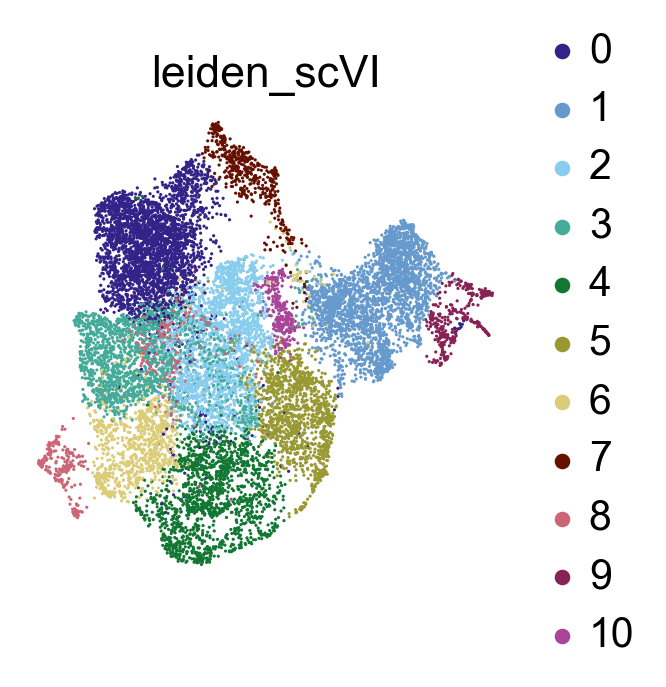

In [79]:
# plot UMAP by leiden
sc.pl.umap(adata, 
           color=['leiden_scVI'], 
           use_raw=False, 
           frameon=False, 
           palette = my_map.html_colors)
           #save = '1_leiden_scVI.png')

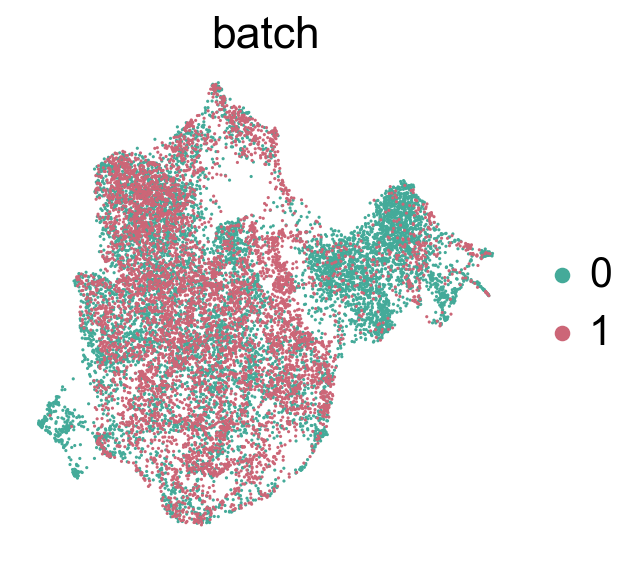

In [73]:
# plot UMAP by batch 
sc.pl.umap(adata, 
           color=['batch'], 
           use_raw=False, 
           frameon=False, 
           palette = ['#44AA99', '#CC6677'])
           #save = '1_umap_batch.png')

In [68]:
# set .X back to scvi norm_log_unscaled to visualize expression of a few genes
adata.X = adata.layers['norm_log_unscaled']

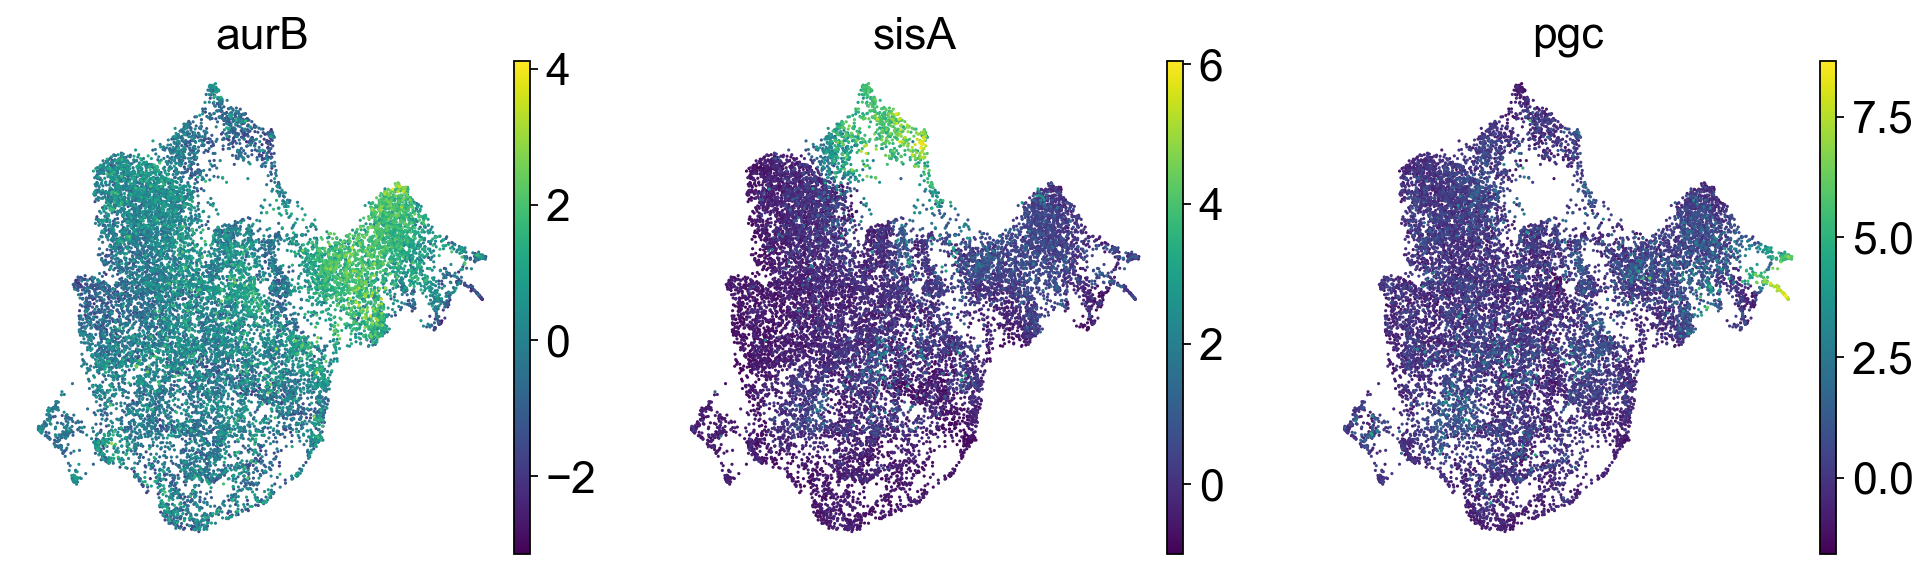

In [70]:
# plot UMAP by expression of aurB (cell cycle), sisA (yolk), and pgc (pole cell)
# will get rid of these later 
sc.pl.umap(adata, 
           color=["aurB", "sisA", "pgc"],
           use_raw = False, 
           frameon=False)
           #save = '1_badgenes.png')

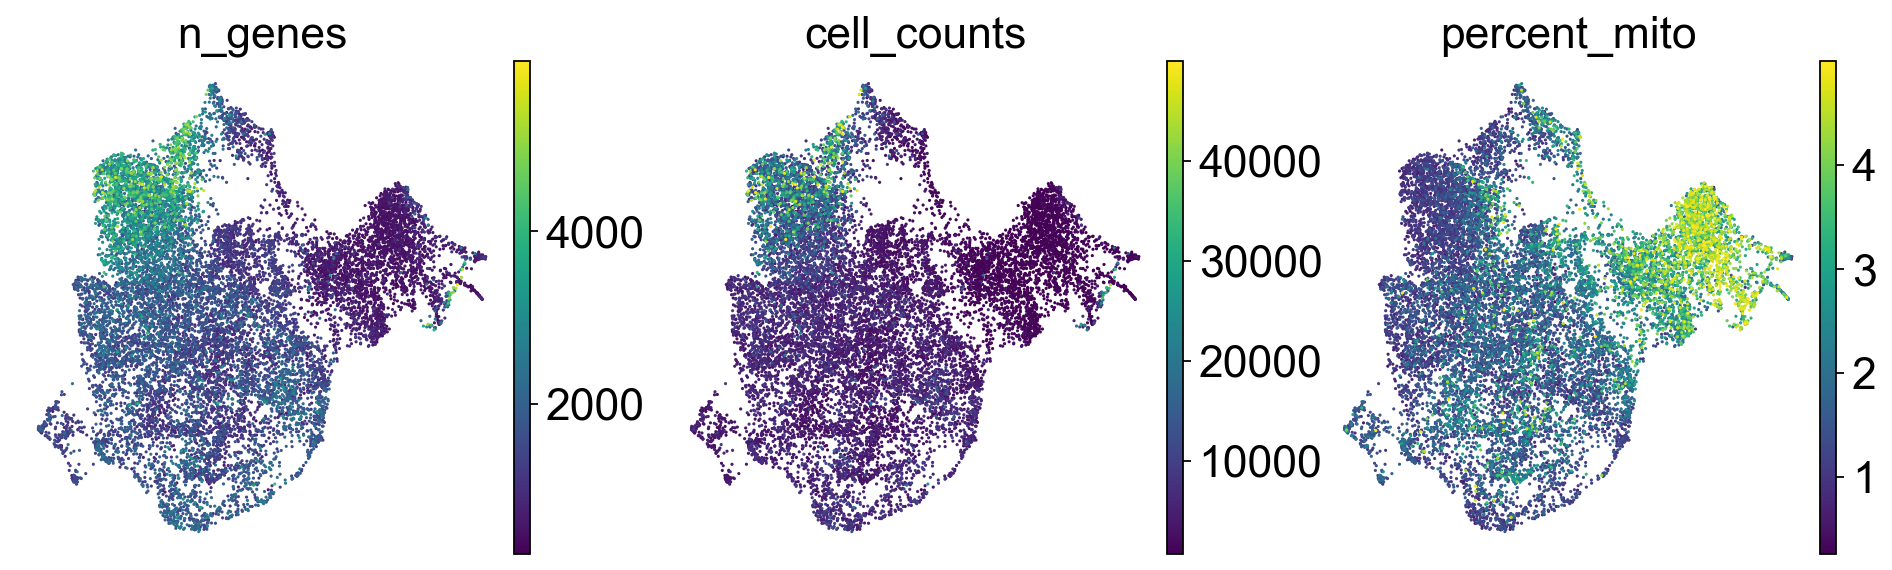

In [67]:
# plot UMAP by quality control metrics 
sc.pl.umap(adata, 
           color=["n_genes", "cell_counts", "percent_mito"],
           use_raw = False, 
           frameon=False)
           #save = '1_QC.png')

## Remove cell cycle, yolk, and pole cell nuclei then re-cluster

In [82]:
# remove cell cycle, yolk, pole cell, high n_genes nuclei... make sure the numbers are right! 
remove_clusters = ['7', '9', '1', '0']
adata = adata[~adata.obs.leiden_scVI.isin(remove_clusters)]

In [84]:
# re-cluster with bad nuclei removed 
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True, n_comps=10)
sc.pp.neighbors(adata, use_rep = 'X_scvi')
sc.tl.leiden(adata, key_added = 'leiden_scVI', resolution = 0.5)

In [85]:
# embed the new neighborhood graph with UMAP
sc.tl.umap(adata, min_dist = 0.3)

In [ ]:
# get colorblind friendly colors
my_map2 = qualitative(10)

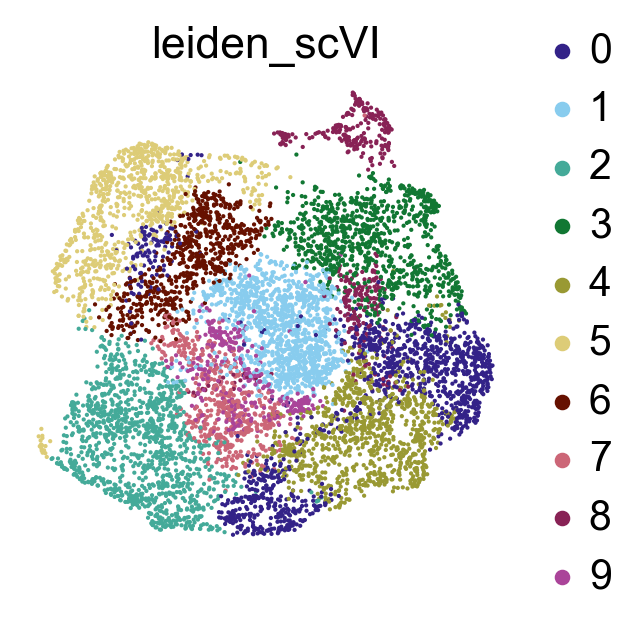

In [91]:
# plot UMAP by leiden
sc.pl.umap(adata, 
           color=['leiden_scVI'], 
           use_raw=False, 
           frameon=False,
           palette = my_map2.html_colors)
           #save = '1_leiden_scVI_after_filter.png')

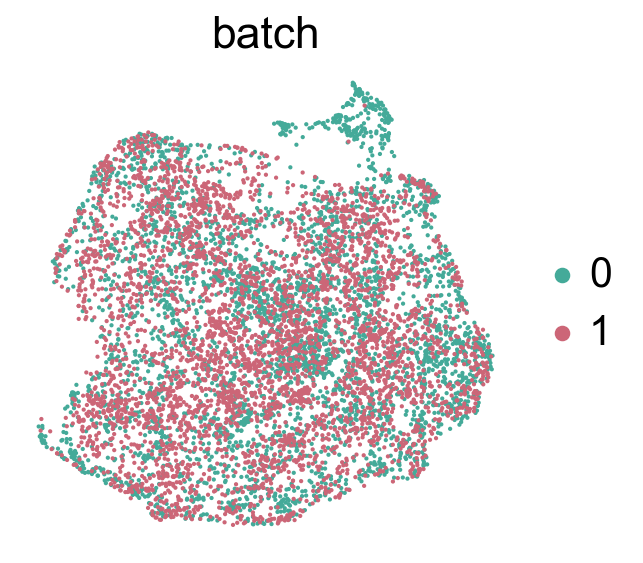

In [88]:
# plot UMAP by batch
sc.pl.umap(adata, 
           color=['batch'], 
           use_raw=False, 
           frameon=False,
           palette = ['#44AA99', '#CC6677'])
           #save = '1_umap_batch_after_filter.png')

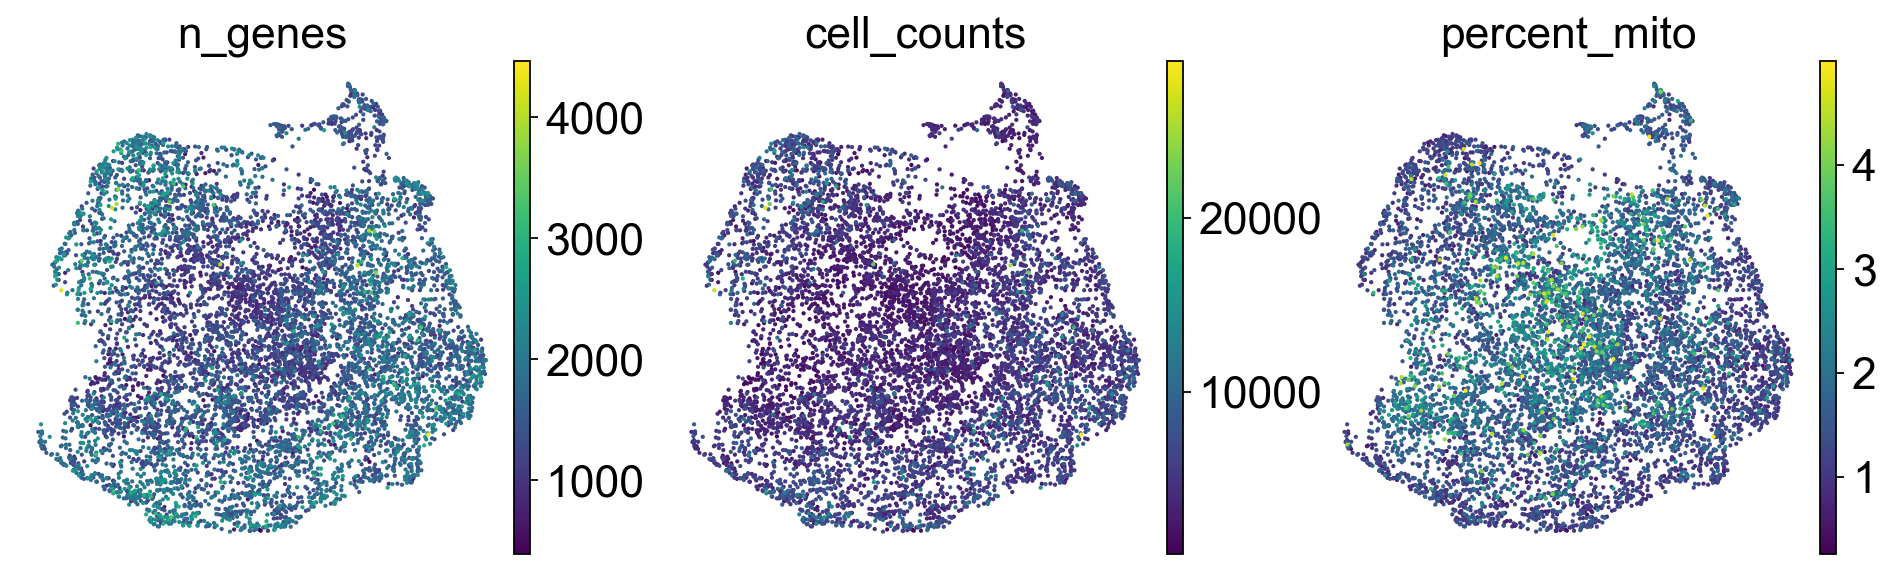

In [27]:
# plot UMAP by quality control
sc.pl.umap(adata, 
           color=["n_genes", "cell_counts", "percent_mito"], 
           use_raw = False, 
           frameon=False)
           #save = '1_umap_QC_after_filter.png')

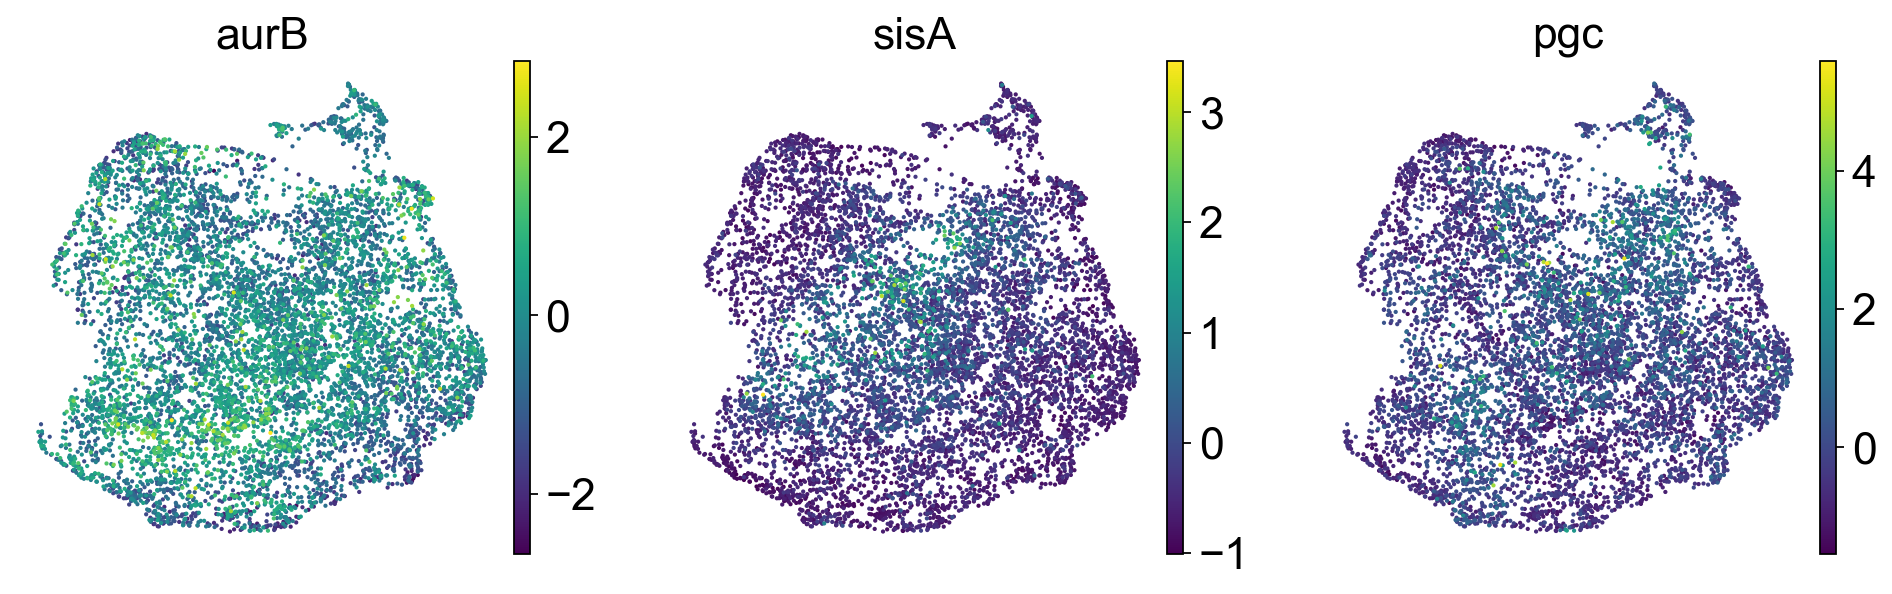

In [28]:
# plot UMAP by expression of aurB (cell cycle), sisA (yolk), and pgc (pole cell)
sc.pl.umap(adata, 
           color=["aurB", "sisA", "pgc"], 
           use_raw=False, 
           frameon=False) 
           #save = '1_umap_badgenes_after_filter.png')

In [29]:
adata

AnnData object with n_obs × n_vars = 8281 × 5999
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'n_counts', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scVI'
    var: 'gene', 'gene_id', 'gene_counts-0', 'n_cells-0', 'gene_counts-1', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', '_scvi', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_scVI_colors', 'batch_colors'
    obsm: 'X_scvi', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw', 'norm', 'log1p', 'X_scvi_norm', 'X_scvi_raw', 'scvi_norm_log', 'norm_log_unscaled'
    obsp: 'distances', 'connectivities'

In [30]:
# adata.write doesn't like _scvi in uns for whatever reason 

adata.uns.pop('_scvi')

{'scvi_version': None,
 'categorical_mappings': {'_scvi_batch': {'original_key': 'batch',
   'mapping': Index(['0', '1'], dtype='object')},
  '_scvi_labels': {'original_key': '_scvi_labels',
   'mapping': Int64Index([0], dtype='int64')}},
 'use_raw': False,
 'data_registry': {'X': {'attr_name': 'layers', 'attr_key': 'raw'},
  'batch_indices': {'attr_name': 'obs', 'attr_key': '_scvi_batch'},
  'local_l_mean': {'attr_name': 'obs', 'attr_key': '_scvi_local_l_mean'},
  'local_l_var': {'attr_name': 'obs', 'attr_key': '_scvi_local_l_var'},
  'labels': {'attr_name': 'obs', 'attr_key': '_scvi_labels'}},
 'summary_stats': {'n_batch': 2,
  'n_cells': 14790,
  'n_genes': 5999,
  'n_labels': 1,
  'n_proteins': 0}}

In [31]:
# save adata
#adata.write('../../results/insulator_withoutcp190_mito5_multimap_6000hvg_070521.h5ad')